In [1]:
from __future__ import division
from math import log, exp, tan, atan, pi, ceil
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import scipy.spatial as spatial
from mayavi import mlab
# mlab.init_notebook()
import glob
from termcolor import colored
import re
import scipy.io as sio
from scipy.interpolate import InterpolatedUnivariateSpline
import shdom

%matplotlib notebook



error: Error -5 while decompressing data: incomplete or truncated stream

In [ ]:
# ----------------------------------------------------
# ----------------------------------------------------# ----------------------------------------------------
# ----------------------------------------------------

def plank(llambda,T):
    h = 6.62607004e-34 # Planck constant
    c = 3.0e8
    k = 1.38064852e-23 # Boltzmann constant
    # https://en.wikipedia.org/wiki/Planck%27s_law
    a = 2.0*h*(c**2)
    b = (h*c)/(llambda*k*T)
    spectral_radiance = a/ ( (llambda**5) * (np.exp(b) - 1.0) )
    return spectral_radiance


# ----------------------------------------------------
# ----------------------------------------------------
# ----------------------------------------------------

def viz3D(cloud_field):
        
    nx,ny,nz = cloud_field.shape
    dx, dy, dz = (1,1,1)
    
    xgrid = np.linspace(0, nx - 1,nx)
    ygrid = np.linspace(0, ny - 1,ny)
    zgrid = np.linspace(0, nz - 1,nz) 
    X, Y, Z = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')
    figh = mlab.gcf()
    src = mlab.pipeline.scalar_field(X, Y, Z, cloud_field)
    src.spacing = [dx, dy, dz]
    src.update_image_data = True 
    
    isosurface = mlab.pipeline.iso_surface(src, contours=[0.1*cloud_field.max(),\
                                                          0.2*cloud_field.max(),\
                                                          0.3*cloud_field.max(),\
                                                          0.4*cloud_field.max(),\
                                                          0.5*cloud_field.max(),\
                                                          0.6*cloud_field.max(),\
                                                          0.7*cloud_field.max(),\
                                                          0.8*cloud_field.max(),\
                                                          0.9*cloud_field.max(),\
                                                          ],opacity=0.9)
    mlab.pipeline.volume(isosurface, figure=figh)
    color_bar = mlab.colorbar(title="volume", orientation='vertical', nb_labels=5)

    mlab.outline(figure=figh,color = (1, 1, 1))  # box around data axes
    mlab.orientation_axes(figure=figh)
    mlab.axes(figure=figh, xlabel="x (km)", ylabel="y (km)", zlabel="z (km)")    
    mlab.show()    
    
# ----------------------------------------------------
# ----------------------------------------------------
# ----------------------------------------------------

# Implenemt notes and expresions

Solar irradiance is often integrated over a given time period in order to report the radiant energy emitted into the surrounding environment (joule per square metre, J/m2), during that time period

Solar radiation (sun spectral radiation) can be approximated as the radiation from a block body at 5900K.


Caclulate the argument:
\begin{align}
B_{\lambda} = \frac{2 h c^2}{\lambda^5} \frac{1}{{\rm exp}^{\frac{h c}{k T \lambda}}-1}
\end{align}

The units of $B_{\lambda}$ is $\frac{W}{m^2\cdot nm \cdot st}$. I whant the irradiance per $nm$ so I need to multiply $B_{\lambda}$ by the solid angle the the sun see the eargth, thus $E_{\lambda} = 6.8 \cdot 10^{-5} B_{\lambda}$ and it of units of $\frac{W}{m^2 \cdot nm}$.

$E_{\lambda}$ is the amount of irradiance per wavelenght that irradiat the TOA from sun. It is defined as the flux passing
through a square-meter and given in units of $\frac{W}{m^2 \cdot nm}$. Then, to model the irradiance at a certaine time of the day, we must multiplie $E_{\lambda}$ by the cosine of the Sun zenith angle $\Phi^{\rm SR}$.
Thus, the solar spectral irradiance at The TOA at a certaine time is,
\begin{align}
L^{\mathrm{TOA}}_{\lambda} = E_{\lambda}\cos{\Phi^{\rm SR}}  
\end{align}.

To calculate the irradiance for a spectral range,
\begin{align}
L^{\mathrm{TOA}} = \int_{\lambda_1}^{\lambda_2}L^{\mathrm{TOA}}_{\lambda}\delta\lambda 
\end{align},

where $L^{\mathrm{TOA}}$ is the irradiance of units $\frac{W}{m^2}$.

Let $\rho_{\lambda}$ be the cloud albedo. Assuming lemberation reflection of the clouds, the reflection (radiance) from the cloud towards the satellites camera is,
\begin{align}
R_{\lambda} = L^{\mathrm{TOA}}_{\lambda} T^{\rm TOA - cloud}  \frac{\rho_{\lambda}}{\pi} T^{\rm cloud - TOA}
\end{align},
where $T^{\rm TOA - cloud} = T^{\rm cloud - TOA}$ are the transmition of atmospher from the TOA towards the cloud.


* h = 6.62607004e-34 J*s is the Planck constant
* c = 3.0e8 m/s speed of litght 
* k = 1.38064852e-23 J/K is the Boltzmann constant
* T is the temperature of the radiation cavity of the black-body.
* $A_p$ is the area seen from the sattelite (on the ground or at the top of the clouds).
* $r_{\rm sat}$ is the distance from an object (e.g. ground, cloud) to observer.
* $A_{\rm lens}$ is the lens area of the CloudCT sat.

* QE (pandas Dataframe): Dataframe of Quantum Efficieny of a specific channel
* QEs (list of DataFrames): Quantum Efficiency graphs of the camera in RGB order.
* ch_index (int): Color channel to process (in order [R, G, B])
* E_ph=hc\λ is photon energy, h is the Planck constant, c is the speed of light in vacuum and λ is the photon's wavelength.


__COMPARISON WITH MITSUBA1__:
In Mitsuba, the intensity of a pixel doesn't dopend on the phonon number emmerged from the pixel. The intensity depends on the irradiance at the TOA. An example how we set the irradiance in Mitsuba's xml for sun ligth:

"""
(<)emitter type="directional(>)"
	(<)vector name="direction" x="0" y="0" z="-1"/(>)
    (<)spectrum name="irradiance" value="1"/(>)
(<)/emitter(>)

"""

The irradiance value is what defined in the spectrum section (currently, value="1").
For the comparison with pyshdom. If we set the $L^{\mathrm{TOA}} = 1$ and $cos{\Phi^{\rm SR}}$ to some value in the range, we get the same radiance measurements as we get on Mitsuba1 (Here, in pyshdon, the flus is set by L_TOA = Cosain*L_TOA).
The intensity of a pixel doesn't depend on its size (small or higt resolution). __It is due to the fact that a pixel sense the radiance and not the irradiance.__ 


# Common parameters:

constant factor should be 1395.703268036305


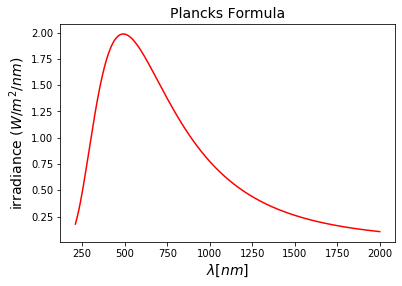

In [4]:
#
# Limits and density of the integraion.
#
start, end = 0.21, 2 # in micro meter [10^-6]
dlambda = 0.005
temp = 5900 #K
xspl = np.linspace(start, end, int((end - start) / dlambda)+1)

# dlambda = 0.005e-6
# wavelengths = np.arange(380e-9, 830e-9, dlambda) # my old 
wavelengths = xspl

# --------------------------------------------------------------------

# from https://socratic.org/questions/how-much-of-the-total-energy-that-leaves-the-sun-makes-it-to-earth-why
# Considering Sun to be situated at the centre of sphere whose radius is equal to the average distance between sun and earth
# which is 1.496×10^8km, erath radius is 6.371x10^3 km
# Solid angle subtended by the area of earth exposed to sun is SA

spectral_radiance_black_body = 6.8e-5*1e-9*plank(1e-6*wavelengths,temp) # units fo W/(m^2 nm) ,
# I am assuming a solid angle of 6.8e-5 steradian for the source (the solar disk).

plt.plot(wavelengths*1e3,spectral_radiance_black_body,color = 'r',label = 'black body at {}K'.format(temp))
plt.title("Plancks Formula", fontsize=14)
plt.xlabel("$\lambda [nm]$", fontsize=14)# sinse x axis is wavelengths*1e3
plt.ylabel("irradiance ($W/m^2/nm$)", fontsize=14)

B = np.trapz(spectral_radiance_black_body, x = xspl*1e3) # x is in nu 
print('constant factor should be {}'.format(B))

For a simple test I assume the ground albedo is 1, no atmosperic particles. So what reflection shoud I get?
No atmosperic particles means atmospheric transmission is 1 (sun->ground,ground->satellite).

Assume that $A_p$ = pixel area at nadir = 50^2 m^2.


In [2]:
# For this simple experiment I  will use Plank function to describe the solar irrradiance.
# I will use a wavelength of 0.652 micro meter.
test_wavelength = 0.672
N = 9
zenith = np.linspace(100,180,N) # Solar beam zenith angle in range (90,180]; Specified in degrees but immediately converted to the cosine of the angle (mu).

# Cosine of solar angle is cos(zenith).
# thus,
Cosain = np.cos(np.deg2rad((180-zenith)))
# L_TOA = 6.8e-5*1e-9*plank(1e-6*test_wavelength,temp) # units fo W/(m^2 nm)
L_TOA = 1 # units fo W/(m^2 nm)
# L_TOA_SHDOM = L_TOA
# ----------------------------------- Cosain = np.ones_like(zenith) # and delete it fast
L_TOA = Cosain*L_TOA

# As the atmospheric transmition and ground albedo are 1 (of cource only for his toy example). 
R = L_TOA/pi # the reflectence in units fo W/(m^2 sr nm).

# Light power gathered by the camera lens is:

# use pyshdom:
mie_table_path = (\
    '../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(test_wavelength)))

"""
solar_flux = L_TOA_SHDOM # it is not correct since shdom probably doesn't scale the flux by the cosine but use the given flux as is/
"""
solar_fluxs = L_TOA


# exclude Rayleigh scattering for air molecules.

# Generate multi-spectral scatterers for both droplets and air molecules
droplets = shdom.MicrophysicalScatterer()
# droplets.load_from_csv('ZeroAtm100x100x10.txt', veff=0.1)
droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/rico32x37x26.txt', veff=0.1)

# Droplet Mie scattering
mie = shdom.MiePolydisperse()
mie.read_table(mie_table_path)
droplets.add_mie(mie)

# plot the droplets lwc:
LWC_MAT = droplets.lwc.data
# viz3D(LWC_MAT)

# Generate an atmospheric medium with both scatterers
atmospheric_grid = droplets.grid
atmosphere = shdom.Medium(atmospheric_grid)
atmosphere.add_scatterer(droplets, name='cloud')

# Generate a solver array for a multispectral solution
rte_solvers = shdom.RteSolverArray()

# rte_solvers = []
numerical_params = shdom.NumericalParameters()
for angle,solar_flux in zip(zenith,solar_fluxs):
    scene_params = shdom.SceneParameters(
        wavelength=test_wavelength,
        surface=shdom.LambertianSurface(albedo=0.05),
        source=shdom.SolarSource(azimuth=0, zenith=angle,flux=solar_flux) # flux=solar_flux
    ) 
    
    # def solver:
    rte_solver = shdom.RteSolver(scene_params, numerical_params)
    rte_solver.set_medium(atmosphere)
    # solve rte
#     rte_solver.solve(maxiter=10)
#     rte_solvers.append(rte_solver)
    rte_solvers.add_solver(rte_solver)




NameError: name 'shdom' is not defined

In [60]:

# solve rte
rte_solvers.solve(maxiter=100)

Render an image by integrating the incoming radiance along the projection geometry defines (pixels).

In [61]:
"""
Render an image by integrating the incoming radiance along the projection geometry defines (pixels).
"""
projection = shdom.OrthographicProjection(
    bounding_box=droplets.grid.bounding_box, 
    x_resolution=0.02, 
    y_resolution=0.02, 
    azimuth=0.0, 
    zenith=0.0,
    altitude='TOA'
)

camera = shdom.Camera(shdom.RadianceSensor(), projection)
images = camera.render(rte_solvers[0], n_jobs=40)
for index in np.arange(1,N):
    image = camera.render(rte_solvers[index], n_jobs=40)
    images = np.dstack((images,image)) 
# imgage shape depth is as the number of solar cosine angles.



<IPython.core.display.Javascript object>


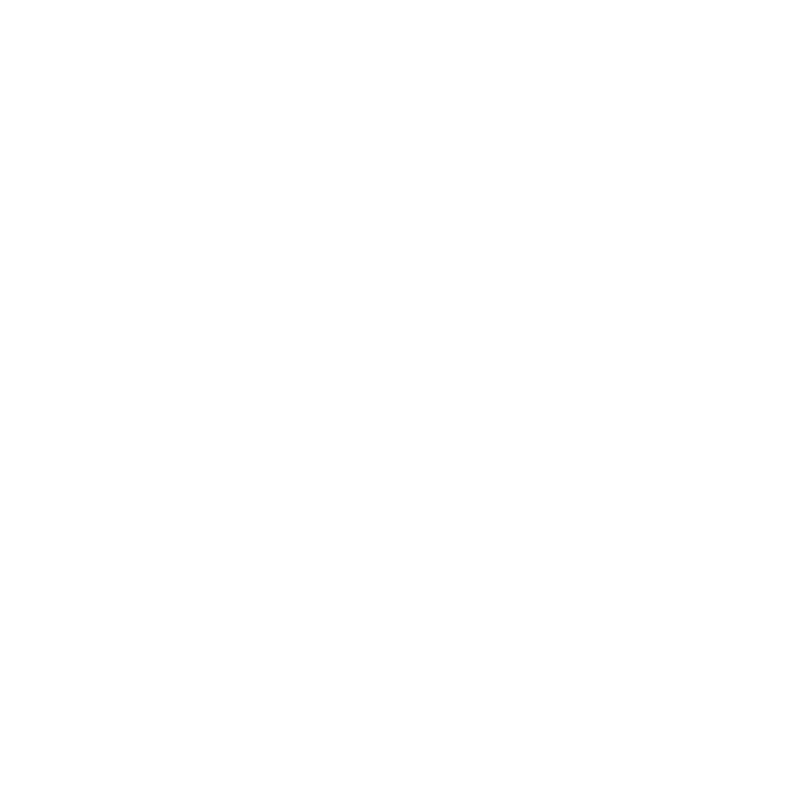

check the intensity of the surface 0.0037417092826217413 against the value of R, which is 0.055273931669183284
check the intensity of the surface 0.006644019857048988 against the value of R, which is 0.10886839289455742
check the intensity of the surface 0.007913249544799328 against the value of R, which is 0.15915494309189537
check the intensity of the surface 0.008155103772878647 against the value of R, which is 0.20460565087967322
check the intensity of the surface 0.009534473530948162 against the value of R, which is 0.24383951950092722
check the intensity of the surface 0.00798819586634636 against the value of R, which is 0.27566444771089604
check the intensity of the surface 0.00638539157807827 against the value of R, which is 0.2991134511701105
check the intensity of the surface 0.01547237765043974 against the value of R, which is 0.3134740437742306
check the intensity of the surface 0.019182104617357254 against the value of R, which is 0.3183098861837907


<IPython.core.display.Javascript object>


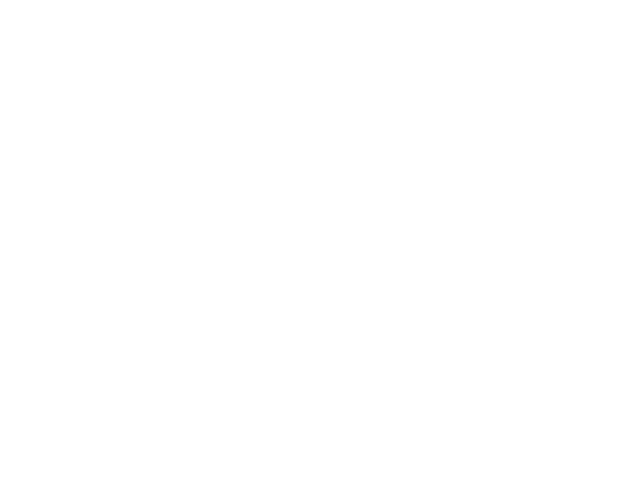

In [52]:
%matplotlib notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, axarr = plt.subplots(3, 3, figsize=(8, 8))

shdoms = np.zeros(N)
ax = axarr.ravel()
for index,angle in enumerate(zenith):
    
    Isize_x,Isize_y = images[:,:,index].shape
    
    check_mean = np.mean(images[int(0.8*Isize_x):-1,int(0.8*Isize_y):-1,index])
    
    print("check the intensity of the surface {} against the value of R, which is {}".format(check_mean,R[index]))
    shdoms[index] = check_mean
    
    
    divider = make_axes_locatable(ax[index])
    cax = divider.append_axes('right', size='5%', pad=0.05)

    solar_angle_deg = (180-angle)
    im = ax[index].imshow(images[:,:,index],vmin=0, vmax=images.max())
    ax[index].invert_xaxis() 
    ax[index].invert_yaxis() 
    ax[index].axis('off')
    ax[index].set_title("Solar angle = {}".format(angle))
    f.colorbar(im, cax=cax, orientation='vertical')

    
plt.figure()
plt.plot(zenith,R,linewidth=2.0,label='Analitic')
plt.plot(zenith,shdoms,linewidth=2.0,label='Shdom',linestyle = '--')
plt.legend()

In [40]:

def Create_free_atmosphere():
    # mediume parameters:
    dx,dy,dz=(1e-3*50,1e-3*50,1e-3*100) # in km
    cloud_field = np.zeros([100,100,10])
    nx,ny,nz = cloud_field.shape
    xgrid = np.linspace(0, nx - 1,nx)
    ygrid = np.linspace(0, ny - 1,ny)
    zgrid = np.linspace(0, nz - 1,nz) 
    X, Y, Z = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')  
    z_min = 0 
    z_max = nz*dz
    zds = np.linspace(z_min, z_max-dz ,nz)


    # set cloud bottom to zero:

    file_name = "ZeroAtm{}x{}x{}.txt"\
        .format(cloud_field.shape[0],cloud_field.shape[1],cloud_field.shape[2])
    # create the txt files:
    comment_line = "for simple simple calibration"
    np.savetxt(file_name, X=np.array([cloud_field.shape]), fmt='%d', header=comment_line)
    f = open(file_name, 'ab') 
    np.savetxt(f, X=np.concatenate((np.array([dx, dy]), zds)).reshape(1,-1), fmt='%2.3f')

    lwc = cloud_field
    lwc = cloud_field
    C = 1
    lwc[1:int(0.5*nx),1,0] = C
    lwc[1,1:nx,0] = C
    lwc[1,1,:] = C
    reff = np.ones_like(lwc)

    y, x, z = np.meshgrid(range(ny), range(nx), range(nz))
    data = np.vstack((x.ravel(), y.ravel(), z.ravel(), lwc.ravel(), reff.ravel())).T
    np.savetxt(f, X=data, fmt='%d %d %d %.5f %.3f')        
    f.close()  
    
    viz3D(lwc)
    
Create_free_atmosphere()


# Use perspective camera:

In [62]:
# A Perspective trasnormation (pinhole camera).

dx = atmospheric_grid.dx
dy = atmospheric_grid.dy

nz = atmospheric_grid.nz
nx = atmospheric_grid.nx
ny = atmospheric_grid.ny

Lx = atmospheric_grid.bounding_box.xmax - atmospheric_grid.bounding_box.xmin
Ly = atmospheric_grid.bounding_box.ymax - atmospheric_grid.bounding_box.ymin
Lz = atmospheric_grid.bounding_box.zmax - atmospheric_grid.bounding_box.zmin
L = max(Lx,Ly)
dz = Lz/(nz-1)

sc = 1
Rsat = 500
cny= sc*ny
cnx = sc*nx

cny= 100
cnx = 100

fov = np.rad2deg(2*np.arctan(0.5*L/(Rsat)))
lookat = [0.5*nx*dx , 0.5*ny*dy , 0]
origin = [(0.5*nx*dx) , 0.5*ny*dy , Rsat]

x, y, z = origin
projection = shdom.PerspectiveProjection(
    fov, 
    cnx, cny, x, y, z)
projection.look_at_transform(lookat,[0,1,0])

camera = shdom.Camera(shdom.RadianceSensor(), projection)
images = camera.render(rte_solvers[0], n_jobs=40)
for index in np.arange(1,N):
    image = camera.render(rte_solvers[index], n_jobs=40)
    images = np.dstack((images,image)) 
# imgage shape depth is as the number of solar cosine angles.



<IPython.core.display.Javascript object>


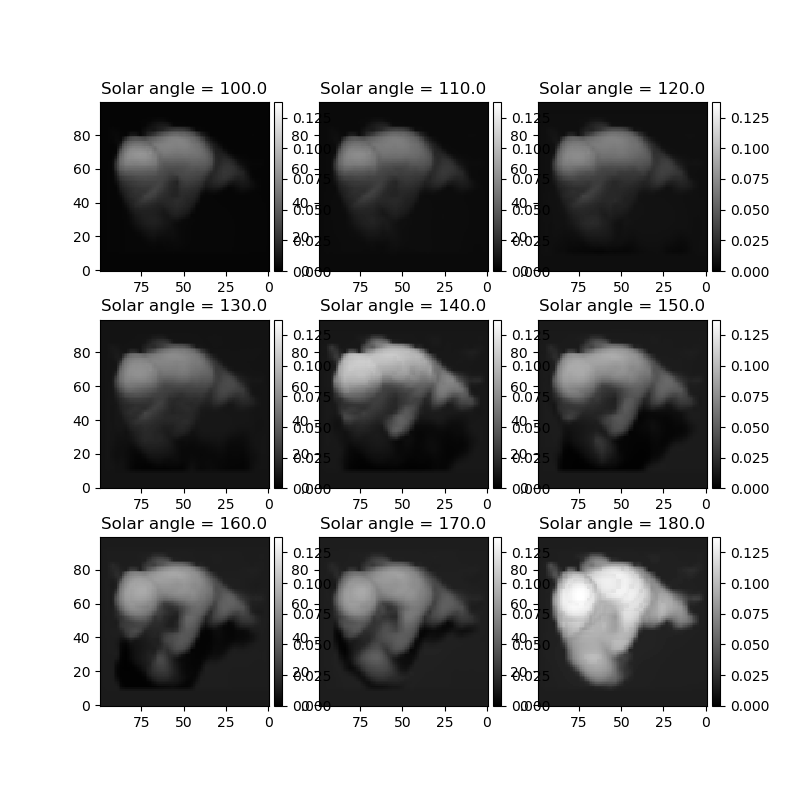

check the intensity of the surface 0.0271881315857172 against the value of R, which is 0.055273931669183284
check the intensity of the surface 0.024588361382484436 against the value of R, which is 0.10886839289455742
check the intensity of the surface 0.023831987753510475 against the value of R, which is 0.15915494309189537
check the intensity of the surface 0.024971196427941322 against the value of R, which is 0.20460565087967322
check the intensity of the surface 0.03434368222951889 against the value of R, which is 0.24383951950092722
check the intensity of the surface 0.035657934844493866 against the value of R, which is 0.27566444771089604
check the intensity of the surface 0.03847423195838928 against the value of R, which is 0.2991134511701105
check the intensity of the surface 0.045879147946834564 against the value of R, which is 0.3134740437742306
check the intensity of the surface 0.09838414937257767 against the value of R, which is 0.3183098861837907


<IPython.core.display.Javascript object>


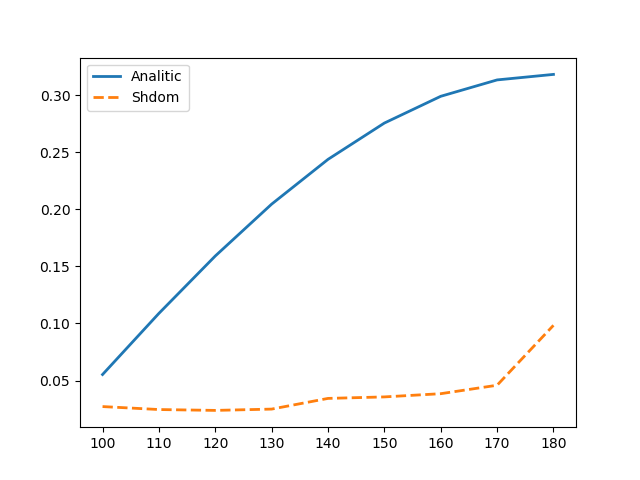

In [63]:
%matplotlib notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, axarr = plt.subplots(3, 3, figsize=(8, 8))

shdoms = np.zeros(N)
ax = axarr.ravel()
for index,angle in enumerate(zenith):
    
    Isize_x,Isize_y = images[:,:,index].shape
    
    check_mean = np.mean(images[(int(0.5*Isize_x)-10):(int(0.5*Isize_x)+10),(int(0.5*Isize_y)-10):(int(0.5*Isize_y)+10),index])
    
    print("check the intensity of the surface {} against the value of R, which is {}".format(check_mean,R[index]))
    shdoms[index] = check_mean
    
    
    divider = make_axes_locatable(ax[index])
    cax = divider.append_axes('right', size='5%', pad=0.05)

    solar_angle_deg = (180-angle)
    im = ax[index].imshow(images[:,:,index],cmap='gray',vmin=0, vmax=images.max())
    ax[index].invert_xaxis() 
    ax[index].invert_yaxis() 
#     ax[index].axis('off')
    ax[index].set_title("Solar angle = {}".format(angle))
    f.colorbar(im, cax=cax, orientation='vertical')

    
plt.figure()
plt.plot(zenith,R,linewidth=2.0,label='Analitic')
plt.plot(zenith,shdoms,linewidth=2.0,label='Shdom',linestyle = '--')
plt.legend()

In [45]:
Lz = atmospheric_grid.bounding_box.zmax - atmospheric_grid.bounding_box.zmin
L = max(Lx,Ly)
dz = Lz/(nz-1)

In [22]:
dz

0.09999999735090467

In [69]:
v = np.arange(1,9)
v

array([1, 2, 3, 4, 5, 6, 7, 8])

In [54]:
Cosain = np.cos(np.deg2rad((180-130)))
Cosain

0.6427876096865394

In [55]:
np.sin(np.deg2rad((180-130)))

0.766044443118978

In [56]:
0.766044443118978**2 + 0.6427876096865394**2

1.0

In [76]:
cny

100

In [59]:
cnx

100

In [48]:
L_TOA

array([0.17364818, 0.34202014, 0.5       , 0.64278761, 0.76604444,
       0.8660254 , 0.93969262, 0.98480775, 1.        ])